# Group Members

## Fam Cham An
## Idoko Simon
## Damindarov Ruslan

### IMPORTS


In [1]:
import sympy as sym
import numpy as np
from math import atan2
import matplotlib.pyplot as plt

### PREPROCESS

In [2]:
### Pretty Printing of outputs

sym.init_printing()
np.set_printoptions(precision=2)

### UTILITIES

#### Stiffness Utils

In [3]:
# Definition of Wrench 
def W(i):
  x, y, z = "x", "y", "z"
  a, b, c, d, e, f = sym.symbols("F_"+f"{i}"+"^x"), sym.symbols(f"F_"+f"{i}"+"^y"), sym.symbols(f"F_"+f"{i}"+"^z"), sym.symbols(f"M_"+f"{i}"+"^x"), sym.symbols(f"M_"+f"{i}"+"^y"), sym.symbols(f"M_"+f"{i}"+"^z")
  return [a, b, c, d, e, f]

In [4]:
# Definition of Deflection
def DeltaT(i):
  x, y, z = "x", "y", "z"
  a, b, c, d, e, f = sym.symbols("p_"+f"{i}"+"^x"), sym.symbols(f"p_"+f"{i}"+"^y"), sym.symbols(f"p_"+f"{i}"+"^z"), sym.symbols(f"phi_"+f"{i}"+"^x"), sym.symbols(f"phi_"+f"{i}"+"^y"), sym.symbols(f"phi_"+f"{i}"+"^z")
  return [a, b, c, d, e, f]

#### Block Matrices Utils

In [5]:
# Create a Square Zero Matrix
def zero_sqr(i):
  return np.zeros((i,i))

# Create a Rectangular Zero matrix of dimension i X j
def zero_rec(i, j):
  return np.zeros((i,j))

In [6]:
# Create Square Identity Matrix of size i
def eye_sqr(i):
  return np.eye(i)

# Rectangular Identity matrix
def eye_rec(i, j):
  eye = np.eye(i)
  return np.delete(eye, j-1, 0)

In [7]:
# Vector of zeros, size i, with a one at position j
def zeros_one(i, j):
  row = np.zeros(i)
  row[j-1] = 1
  return row

#### Rotation Matrices Utils

In [8]:
# Rotation around x-axis by q
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


# Rotation around y-axis by q
def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


# Rotation around z-axis by q
def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T

#### Translation Matrices Utils

In [9]:
# Translation along x-axis by x
def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


# Translation along y-axis by y
def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


# Translation along z-axis by z
def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T


# KINEMATICS

#### Forward Kinematics

#### Inverse Kinematics

In [10]:
# Returns the join parameter variable, i.e. Inverse Kinematics of a single leg
def IK_Leg(T_base, pos__g, link_params={'L':1}):
  """Pos_e_g represents the global position of the end effector"""
  
  l1 = link_params['L']
  l2 = l1

  R_base = T_base[0:3, 0:3]
  p_base = T_base[0:3, 3]
  pos__loc = np.transpose(R_base).dot(pos__g - p_base)

  x, y, z = pos__loc[:3]

  D = (x**2 + y**2 - l1**2 - l2**2)/(2*l1*l2)
  cos_q2 = D
  sin_q2 = np.sqrt(1 - D**2)

  q2 = atan2(sin_q2, cos_q2)
  q1 = atan2(y, x) - atan2(l2*sin_q2, l1 + l2*cos_q2)
  q3 = -q1 - q2

  q = q1, q2, q3

  return np.asarray(q)

In [11]:
# Returns the inverse kinematics for all the joint parameters of the robot, given the bases of the legs and the end effector position
def IK_Tripetron(T_base_list, pos__g):
  q_total = []
  for T_base in T_base_list:
    q = IK_Leg(T_base, pos__g)
    q_total.append(q)
  
  return np.asarray(q_total)

# MSA

### STIFFNESS MATRIX

In [12]:
# Function that returns the K11 Stiffness matrix for a link given the link parameters and the Rotation relative to the global origin
def K_11(params, Q):
  a, e, G, l, I_x, I_y, I_z, I_p = params['A'], params['E'], params['G'], params['l'], params['Ix'],params['Iy'], params['Iz'], params['Ip']
  k = np.array([
          [ (a*e)/l,  0,                0,                0,            0,                0               ],
          [ 0,        (12*e*I_z)/l**3,  0,                0,            0,                (6*e*I_z)/l**2  ],
          [ 0,        0,                (12*e*I_y)/l**3,  0,            -(6*e*I_y)/l**2,  0               ],
          [ 0,        0,                0,                (G*I_p)/l,    0,                0               ],
          [ 0,        0,                -(6*e*I_y)/l**2,  0,            (4*e*I_y)/l,      0               ],
          [ 0,        (6*e*I_z)/l**2,   0,                0,            0,                (4*e*I_z)/l     ]
  ]) 
  return np.linalg.multi_dot([ Q, k, Q.transpose() ])

In [13]:
# Function that returns the K22 Stiffness matrix for a link given the link parameters and the Rotation relative to the global origin
def K_22(params, Q):
  a, e, G, l, I_x, I_y, I_z, I_p = params['A'], params['E'], params['G'], params['l'], params['Ix'],params['Iy'], params['Iz'], params['Ip']
  k = np.array([
          [ (a*e)/l,  0,                0,                0,            0,                0               ],
          [ 0,        (12*e*I_z)/l**3,  0,                0,            0,                -(6*e*I_z)/l**2 ],
          [ 0,        0,                (12*e*I_y)/l**3,  0,            (6*e*I_y)/l**2,   0               ],
          [ 0,        0,                0,                (G*I_p)/l,    0,                0               ],
          [ 0,        0,                (6*e*I_y)/l**2,   0,            (4*e*I_y)/l,      0               ],
          [ 0,        -(6*e*I_z)/l**2,  0,                0,            0,                (4*e*I_z)/l     ]
  ]) 
  return np.linalg.multi_dot([ Q, k, Q.transpose() ])

In [14]:
# Function that returns the K12 Stiffness matrix for a link given the link parameters and the Rotation relative to the global origin
def K_12(params, Q):
  a, e, G, l, I_x, I_y, I_z, I_p = params['A'], params['E'], params['G'], params['l'], params['Ix'],params['Iy'], params['Iz'], params['Ip']
  k = np.array([
          [ -(a*e)/l, 0,                0,                0,            0,                0               ],
          [ 0,        -(12*e*I_z)/l**3, 0,                0,            0,                (6*e*I_z)/l**2 ],
          [ 0,        0,                -(12*e*I_y)/l**3, 0,            -(6*e*I_y)/l**2,   0               ],
          [ 0,        0,                0,                -(G*I_p)/l,   0,                0               ],
          [ 0,        0,                (6*e*I_y)/l**2,  0,            (2*e*I_y)/l,      0               ],
          [ 0,        -(6*e*I_z)/l**2,   0,                0,            0,                (2*e*I_z)/l     ]
  ]) 
  return np.linalg.multi_dot([ Q, k, Q.transpose() ])

# Function that returns the K21 Stiffness matrix for a link given the link parameters and the Rotation relative to the global origin
def K_21(params, Q): 
  a, e, G, l, I_x, I_y, I_z, I_p = params['A'], params['E'], params['G'], params['l'], params['Ix'],params['Iy'], params['Iz'], params['Ip']
  k = np.array([
          [ -(a*e)/l, 0,                0,                0,            0,                0               ],
          [ 0,        -(12*e*I_z)/l**3, 0,                0,            0,                (6*e*I_z)/l**2 ],
          [ 0,        0,                -(12*e*I_y)/l**3, 0,            -(6*e*I_y)/l**2,   0               ],
          [ 0,        0,                0,                -(G*I_p)/l,   0,                0               ],
          [ 0,        0,                (6*e*I_y)/l**2,  0,            (2*e*I_y)/l,      0               ],
          [ 0,        -(6*e*I_z)/l**2,   0,                0,            0,                (2*e*I_z)/l     ]
  ]) 
  k = np.transpose(k)
  return np.linalg.multi_dot([ Q, k, Q.transpose() ])

### AGGREGATE MATRIX A

In [15]:
# Definitions of the passive and elastic joints matrices
lambda_r12 = [eye_rec(6,1), eye_rec(6,2), eye_rec(6,3)]
lambda_e12 = [zeros_one(6,1), zeros_one(6,2), zeros_one(6,3)]
lambda_r34 = lambda_r56 = lambda_r78 = [eye_rec(6,4), eye_rec(6,5), eye_rec(6,6)]
lambda_p34 = lambda_p56 = lambda_p78 = [zeros_one(6,4), zeros_one(6,5), zeros_one(6,6)]
 

In [16]:
# Definition of the A aggregate Matrix (102 X 102)
def A_agg(Q_list, i):
  # Rigid base connection to link 1
  Lb_1 = np.block([ zero_rec(6,54), eye_sqr(6), zero_rec(6,42) ])

  # TODO: Define Ka value. 
  Ka=1000000
  # Elastic Joint Link 1 to 2
  L1_2 = np.block([ 
              [ zero_rec(5,54), lambda_r12[i], -1*lambda_r12[i], zero_rec(5,36)],
              [ eye_sqr(6), eye_sqr(6), zero_rec(6,90) ],
              [ lambda_e12[i], zero_rec(1,48), Ka*lambda_e12[i], -Ka*lambda_e12[i], zero_rec(1,36) ]])

  # Rigid Link 2 to 3
  L2_3 = np.block([
              [ zero_rec(6,60), eye_sqr(6), -1*eye_sqr(6), zero_rec(6,30) ],
              [ zero_rec(6,6), eye_sqr(6), eye_sqr(6), zero_rec(6,84) ]])

  # Passive Joint Link 3 to 4
  L3_4 = np.block([
              [ zero_rec(5,66), lambda_r34[i], -1*lambda_r34[i], zero_rec(5,24) ],
              [ zero_rec(5,12), lambda_r34[i], lambda_r34[i], zero_rec(5,78) ],
              [ zero_rec(1,12), lambda_p34[i], zero_rec(1,84) ],
              [ zero_rec(1,18), lambda_p34[i], zero_rec(1,78) ]])

  # TODO: Definition of Stiffness matrix
  d = 0.15
  # L4_5Params = { 'A':1, 'E':660, 'G':0.5, 'l':1, 'Ix':1, 'Iy':1, 'Iz':1, 'Ip':1}
  L4_5Params = { 'A':np.pi*(d**2)/4, 'E':70*10**9, 'G':25.2*10**9, 'l':1, 'Ix':np.pi*(d**4)/64, 'Iy':np.pi*(d**4)/64, 'Iz':np.pi*(d**4)/64, 'Ip':np.pi*(d**4)/32}
  Q4_5 = Q_list[0]

  # Flexible Link 4 to 5
  L4_5 = np.block([
              [ zero_rec(6,18), -1*eye_sqr(6), zero_rec(6,48), K_11(L4_5Params,Q4_5), K_12(L4_5Params,Q4_5), zero_rec(6,18) ],
              [ zero_rec(6,24), -1*eye_sqr(6), zero_rec(6,42), K_21(L4_5Params,Q4_5), K_22(L4_5Params,Q4_5), zero_rec(6,18) ]])

  # Passive Joint of Link 5 to 6
  L5_6 = np.block([
              [ zero_rec(5,78), lambda_r56[i], -1*lambda_r56[i], zero_rec(5,12) ],
              [ zero_rec(5,24), lambda_r56[i], lambda_r56[i], zero_rec(5,66) ],
              [ zero_rec(1,24), lambda_p56[i], zero_rec(1,72) ],
              [ zero_rec(1,30), lambda_p56[i], zero_rec(1,66) ]])

  # TODO: Definition of Stiffness matrix
  # L6_7Params = { 'A':1, 'E':660, 'G':0.5, 'l':1, 'Ix':1, 'Iy':1, 'Iz':1, 'Ip':1}
  L6_7Params = { 'A':np.pi*(d**2)/4, 'E':70*10**9, 'G':25.2*10**9, 'l':1, 'Ix':np.pi*(d**4)/64, 'Iy':np.pi*(d**4)/64, 'Iz':np.pi*(d**4)/64, 'Ip':np.pi*(d**4)/32}
  Q6_7 = Q_list[1]
  
  # Flexible Link 6 to 7
  L6_7 = np.block([
              [ zero_rec(6,30), -1*eye_sqr(6), zero_rec(6,48), K_11(L6_7Params,Q6_7), K_12(L6_7Params,Q6_7), zero_rec(6,6) ],
              [ zero_rec(6,36), -1*eye_sqr(6), zero_rec(6,42), K_21(L6_7Params,Q6_7), K_22(L6_7Params,Q6_7), zero_rec(6,6) ]])

  # Passive Joint of Link 7 to 8
  L7_8 = np.block([
              [ zero_rec(5,90), lambda_r78[i], -1*lambda_r78[i] ],
              [ zero_rec(5,36), lambda_r78[i], lambda_r78[i], zero_rec(5,54) ],
              [ zero_rec(1,36), lambda_p78[i], zero_rec(1,60) ],
              [ zero_rec(1,42), lambda_p78[i], zero_rec(1,54) ]])

  # Rigid Link Link 8 to End-effector
  d_8_e = np.array([[0, -0.1, 0.1], [0.1, 0, -0.1], [-0.1, 0.1, 0]])
  skew_mat = -1*np.block([[ eye_sqr(3), d_8_e ], [ zero_sqr(3), eye_sqr(3) ]])
  L8_e = np.block([
              [ zero_rec(6,96), skew_mat ],
              [ zero_rec(6,42), eye_sqr(6), eye_sqr(6), zero_rec(6,48) ]])

  ### AGGREGATE MATRIX A
  A = np.block([ [Lb_1], [L4_5], [L6_7], [L8_e], [L2_3], [L1_2], [L3_4], [L5_6], [L7_8] ])

  return A

### AGGREGATE MATRIX B

In [17]:
# Definition of the B Aggregate Matrix (102 X 6)
def B_agg():
  return np.block([
          [zero_rec(6,6)],                                                        # Base to Link 1
          [zero_rec(6,6)], [zero_rec(6,6)],                                       # Link 4 to 5
          [zero_rec(6,6)], [zero_rec(6,6)],                                       # Link 6 to 7          
          [-1*eye_sqr(6)], [zero_rec(6,6)],                                       # Link 8 to e
          [zero_rec(5,6)], [zero_rec(5,6)], [zero_rec(1,6)], [zero_rec(1,6)],     # Link 2 to 3
          [zero_rec(6,6)], [zero_rec(6,6)],                                       # Link 1 to 2
          [zero_rec(5,6)], [zero_rec(6,6)], [zero_rec(1,6)],                      # Link 3 to 4   
          [zero_rec(5,6)], [zero_rec(5,6)], [zero_rec(1,6)], [zero_rec(1,6)],     # Link 5 to 6
          [zero_rec(5,6)], [zero_rec(5,6)], [zero_rec(1,6)], [zero_rec(1,6)]      # Link 7 to 8
  ])

### AGREGATE MATRIX C

In [18]:
# Definition of the C Aggregate Matrix (6 X 102)
def C_agg():
  return np.block([ zero_rec(6,48), -1*eye_sqr(6), zero_rec(6,48) ])

### AGGREGATE MATRIX D

In [19]:
# Definition of the C Aggregate Matrix (6 X 6)
def D_agg():
  return np.block([ zero_rec(6,6) ])

### COMBINED AGGREGATE MATRIX

In [20]:
# The Total Aggraget Matrix
def AGG_mat(Q_list):
  return np.block([
            [ A_agg(Q_list, i),  B_agg() ],
            [ C_agg(),        D_agg() ]])

### K_C MATRIX

In [21]:
# Fucntion that Returns the KC Matrix for one Leg
def KC_leg(Q_list, i):
  Kc = D_agg() - np.linalg.multi_dot([ C_agg(), np.linalg.inv(A_agg(Q_list, i)), B_agg() ]) 
  return Kc

### Delta_T_e Column Matrix

In [22]:
# Function Returns the total Deflection of the Robot, given the necessary Stiffness matrix Rotations and the End-effector wrench
def deflection_ee_tripetron(Q_list_list, We=np.array([1000, 0, 0, 0, 0, 0])):
  KC_total = []
  for i, Q_list in enumerate(Q_list_list):
    # KC_total += KC_leg(Q_list)
    KC_total.append(KC_leg(Q_list, i))
    # print(len(Q_list_list))
    
  KC_total = KC_total[0] + KC_total[1] + KC_total[2]

  d_te = np.dot(np.linalg.inv(KC_total), We)

  return d_te
  

# DEFLECTION PLOT

In [23]:
np.set_printoptions(precision=5, suppress=True, linewidth=200)

#### Deflection Data function

In [24]:
# Robot Height, Width and Breadth
h, w, b = 1, 1, 1
      
# Robot leg base transformations
T_base_leg_z = np.eye(4, dtype=float) 
T_base_leg_y = np.linalg.multi_dot([ Tz(h), Rx(-np.pi/2) ])
T_base_leg_x = np.linalg.multi_dot([Ty(w), Ry(np.pi/2), Rz(np.pi)])
T_base_list = np.array([T_base_leg_x, T_base_leg_y, T_base_leg_z])

# Function Calculates the total Deflections for all posible end_effector positions for a specific End Effector Wrench 
def get_wrench_deflection_plot_data(W_e=np.array([1000, 0, 0, 0, 0, 0])):
  X = np.zeros((10,10,10))
  Y = np.zeros((10,10,10))
  Z = np.zeros((10,10,10))
  deflections = np.zeros((10, 10, 10))

  for z in np.arange(0.01, h, 0.1):
    for y in np.arange(0.01, w, 0.1):
      for x in np.arange(0.01, b, 0.1):
        # Inverse kinematics to get join variables
        q_list = IK_Tripetron(T_base_list, np.array([ x, y, z])) # q1, q2, q3
        # q_list = np.transpose(q_list)

        pos = [x,y,z]

        # Get Striffness Rotation Matrices
        Q_list_list = []
        for i, (q, R_base) in enumerate(zip(q_list, T_base_list)):
          RTb_1 = np.linalg.multi_dot([ R_base, Tz(pos[i]), Rz(q[0]) ])
          RTb_2 = np.linalg.multi_dot([ RTb_1, Tx(w), Rz(q[1]) ])

          Rb_1 = RTb_1[0:3,0:3]
          Rb_2 = RTb_2[0:3,0:3]
          # print(q[1])
          Qb_4 = np.block([[ Rb_1, zero_sqr(3) ],[ zero_sqr(3), Rb_1 ]])
          Qb_6 = np.block([[ Rb_2, zero_sqr(3) ],[ zero_sqr(3), Rb_2 ]])

          Q_list_list.append([Qb_4, Qb_6])
          Q_list_list
          # Total Robot deflection at current end_effector position
        dt_e = deflection_ee_tripetron(Q_list_list, W_e) 

        # Add to Matrices to be used to plot deflection map
        deflections[int(x*10)][int(y*10)][int(z*10)] = np.linalg.norm(dt_e[:3])
        X[int(x*10)][int(y*10)][int(z*10)] = x
        Y[int(x*10)][int(y*10)][int(z*10)] = y
        Z[int(x*10)][int(y*10)][int(z*10)] = z
  return [ X, Y, Z, deflections ]

#### Deflection Plot Function

In [25]:
space_x = 1
space_y = 1
space_z = 1

# Function to Plot the deflection Map
def plotDeflection(x, y, z, deflection, cmap, s):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0, space_x)
    ax.set_ylim3d(0, space_y)
    ax.set_zlim3d(0, space_z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    r = [0,1]
    X, Y = np.meshgrid(r, r)
    ones = np.ones(4).reshape(2, 2)
    zeros = np.zeros(4).reshape(2, 2)
    ax.plot_wireframe(X,Y,ones, alpha=0.5, color='slategray')
    ax.plot_wireframe(X,Y,zeros, alpha=0.5, color='slategray')
    ax.plot_wireframe(X,zeros,Y, alpha=0.5, color='slategray')
    ax.plot_wireframe(X,ones,Y, alpha=0.5, color='slategray')
    ax.plot_wireframe(ones,X,Y, alpha=0.5, color='slategray')
    ax.plot_wireframe(zeros,X,Y, alpha=0.5, color='slategray')

    
    cmap = ax.scatter3D(x, y, z, c=deflection, cmap=cmap, s=s)
    cmap.set_clim(0.0011, 0.0014)
    plt.colorbar(cmap)
    plt.show()

#### wrench = [100, 0, 0, 0, 0, 0] 

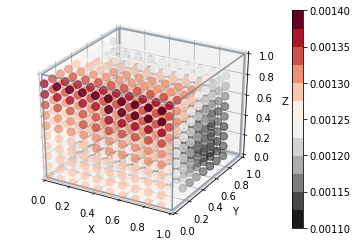

In [26]:
X, Y, Z, deflections = get_wrench_deflection_plot_data(W_e=np.array([100, 0, 0, 0, 0, 0]))
cmap = plt.cm.get_cmap('RdGy_r', 12)
plotDeflection(X, Y, Z, deflections, cmap, 60)

#### wrench = [0, 100, 0, 0, 0, 0] 

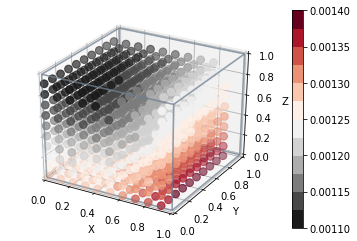

In [27]:
X, Y, Z, deflections = get_wrench_deflection_plot_data(W_e=np.array([0, 100, 0, 0, 0, 0]))
cmap = plt.cm.get_cmap('RdGy_r', 12)
plotDeflection(X, Y, Z, deflections, cmap, 60)

#### wrench = [0, 0, 100, 0, 0, 0] 

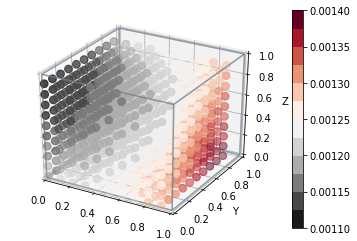

In [31]:
X, Y, Z, deflections = get_wrench_deflection_plot_data(W_e=np.array([0, 0, 100, 0, 0, 0]))
cmap = plt.cm.get_cmap('RdGy_r', 12)
plotDeflection(X, Y, Z, deflections, cmap, 60)